In [1]:
import os

## Set directory
os.chdir('/home/ch416/GeneSys')

from genesys_train_v1 import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
## Conda Env pytorch-gpu on Workstation
## pytorch version
print(torch.__version__)
## scanpy
print(sc.__version__) 

2.2.0.dev20231009+cu118
1.9.5


In [3]:
## Genes considered/used (shared among samples) 
gene_list = pd.read_csv('./gene_list_SCT.csv')

## Load Data

In [5]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [6]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [7]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [8]:
logger = {'tloss': [], 'val_acc': []}
best_val_acc = 0
best_loss = 10000
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            ## time bins
            #t = np.random.choice(time_bins)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= best_val_acc) & (s < best_loss):
        # print('Model improved')
        best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310.pkl', 'wb') as f:
    pickle.dump(logger, f)

Epoch 0 Train: 3991.3352: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.5420
3991.3352263077463


Epoch 1 Train: 2452.6406: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9912
2452.6405984629755


Epoch 2 Train: 2435.9042: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9979
2435.904188073199


Epoch 3 Train: 2489.5491: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9996


Epoch 4 Train: 2420.9706: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 0.9998
2420.9706243984933


Epoch 5 Train: 2432.7674: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9948


Epoch 6 Train: 2417.9617: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9975


Epoch 7 Train: 2404.8135: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9992


Epoch 8 Train: 2330.4652: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9990


Epoch 9 Train: 2364.6838: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9979


Epoch 10 Train: 2355.7909: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9972


Epoch 11 Train: 2355.5492: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9986


Epoch 12 Train: 2357.6287: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00013: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9970


Epoch 13 Train: 2320.9375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9983


Epoch 14 Train: 2354.1874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9987


Epoch 15 Train: 2356.7251: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9986


Epoch 16 Train: 2340.1308: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 17 Train: 2275.3946: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9994


Epoch 18 Train: 2239.4408: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9992


Epoch 19 Train: 2300.493: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9988


Epoch 20 Train: 2283.816: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9993


Epoch 21 Train: 2272.3028: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9989


Epoch 22 Train: 2305.0022: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 23 Train: 2295.3074: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 24 Train: 2229.0589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Epoch 00025: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9996


Epoch 25 Train: 2230.0028: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 26 Train: 2291.1747: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 27 Train: 2276.938: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 28 Train: 2263.2489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995


Epoch 29 Train: 2221.8494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 30 Train: 2230.1759: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9995


Epoch 31 Train: 2218.0524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9993


Epoch 32 Train: 2224.0901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9996


Epoch 33 Train: 2239.6648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9986


Epoch 34 Train: 2230.2502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998
2230.250218488168


Epoch 35 Train: 2233.8104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 00036: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9997


Epoch 36 Train: 2207.8376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 37 Train: 2221.1379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 38 Train: 2206.0711: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998
2206.0711245329467


Epoch 39 Train: 2232.7146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 40 Train: 2200.2119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 41 Train: 2158.921: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998
2158.9209727411703


Epoch 42 Train: 2196.8077: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 43 Train: 2157.8292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 44 Train: 2198.8141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 45 Train: 2223.0444: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 46 Train: 2229.537: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 47 Train: 2173.0866: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9996


Epoch 48 Train: 2173.0912: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 49 Train: 2228.4458: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 50 Train: 2214.957: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995


Epoch 51 Train: 2235.269: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 00052: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 0.9997


Epoch 52 Train: 2190.2076: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9995


Epoch 53 Train: 2212.5378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 54 Train: 2249.3194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9994


Epoch 55 Train: 2209.2863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 56 Train: 2186.3431: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 57 Train: 2177.3475: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 58 Train: 2150.4147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 59 Train: 2137.4574: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9995


Epoch 60 Train: 2225.6529: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9998


Epoch 61 Train: 2163.7785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9995


Epoch 62 Train: 2205.2593: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Epoch 00063: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 0.9997


Epoch 63 Train: 2233.9637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 64 Train: 2201.581: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 65 Train: 2131.8623: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9998
2131.8623206097163


Epoch 66 Train: 2156.7777: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 67 Train: 2169.5954: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9997


Epoch 68 Train: 2183.0341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9993


Epoch 69 Train: 2247.059: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9993


Epoch 70 Train: 2250.2438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9998


Epoch 71 Train: 2198.4115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 72 Train: 2225.2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9994


Epoch 73 Train: 2175.5385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 00074: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 0.9997


Epoch 74 Train: 2226.8229: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 75 Train: 2161.8696: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 76 Train: 2148.2015: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 77 Train: 2193.6267: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 78 Train: 2156.0394: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 79 Train: 2206.8039: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9996


Epoch 80 Train: 2199.3891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995


Epoch 81 Train: 2180.8874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 82 Train: 2201.2163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9996


Epoch 83 Train: 2190.9125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9994


Epoch 84 Train: 2201.7583: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Epoch 00085: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 0.9995


Epoch 85 Train: 2180.3914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 86 Train: 2222.6735: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 87 Train: 2199.3284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995


Epoch 88 Train: 2151.9225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9993


Epoch 89 Train: 2221.9272: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 90 Train: 2194.8837: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9995


Epoch 91 Train: 2182.7944: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9995


Epoch 92 Train: 2173.8004: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9991


Epoch 93 Train: 2231.2964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9996


Epoch 94 Train: 2170.5856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 95 Train: 2133.2343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00096: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 0.9994


Epoch 96 Train: 2163.7286: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 97 Train: 2192.8299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 98 Train: 2204.7162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995


Epoch 99 Train: 2125.0193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999
2125.0193224920745


In [9]:
#100 epochs
print(best_val_acc)
print(best_loss)

0.9998851102941176
2125.0193224920745


In [10]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310.csv")
log = pd.read_csv("log_root_atlas_20240310.csv", index_col=0)

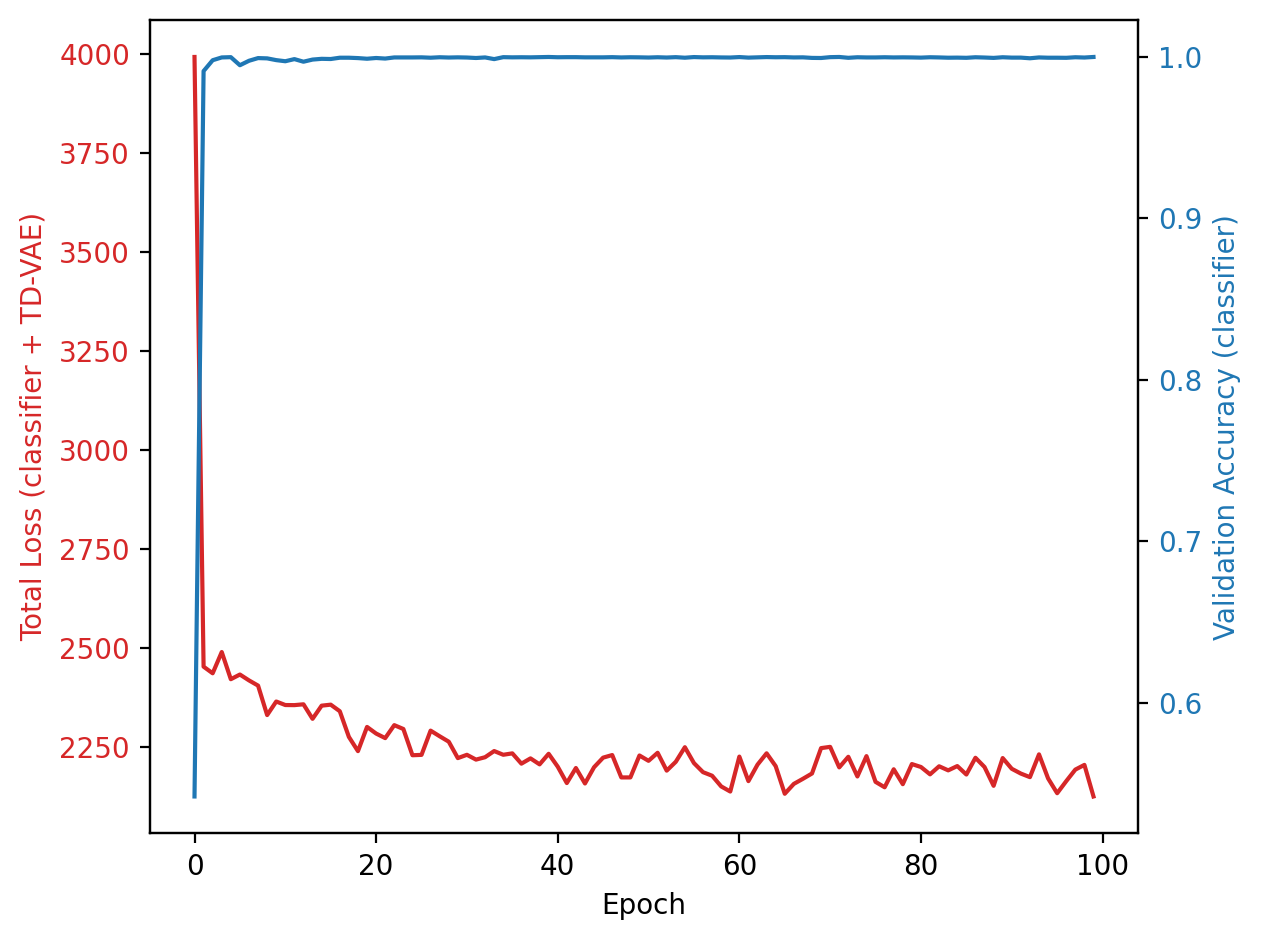

In [11]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [12]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

2125.0193224920745

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 2179.0625: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9997


Epoch 1 Train: 2211.2649: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 2210.3958: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9993


Epoch 3 Train: 2171.6603: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9998


Epoch 4 Train: 2135.8674: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9998


Epoch 5 Train: 2175.7003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 6 Train: 2244.3764: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9867


Epoch 7 Train: 2214.4502: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 8 Train: 2186.7282: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9998


Epoch 9 Train: 2213.5428: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9997


Epoch 10 Train: 2143.5343: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 11 Train: 2172.863: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9995


Epoch 12 Train: 2157.3169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 13 Train: 2161.0497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 14 Train: 2204.8481: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 15 Train: 2171.6611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 2140.4649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 17 Train: 2129.3551: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 2155.6791: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9998


Epoch 19 Train: 2168.3916: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 2083.0727: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999
2083.0726928710947


Epoch 21 Train: 2187.7254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 22 Train: 2195.8647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9995


Epoch 23 Train: 2183.6446: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9994


Epoch 24 Train: 2173.2576: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 25 Train: 2165.2693: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 26 Train: 2138.0748: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 27 Train: 2105.6902: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 2159.1901: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 29 Train: 2116.6305: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 30 Train: 2127.3911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 31 Train: 2140.2848: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 2137.2943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 33 Train: 2178.196: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9998


Epoch 34 Train: 2129.1389: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 35 Train: 2110.5715: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 36 Train: 2177.12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 2137.7471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 38 Train: 2099.2929: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9998


Epoch 39 Train: 2075.3943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999
2075.3942605723505


Epoch 40 Train: 2131.4054: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 41 Train: 2162.4476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 42 Train: 2129.4238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 43 Train: 2152.196: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9998


Epoch 44 Train: 2103.5891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 0.9998


Epoch 45 Train: 2182.7605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 2128.8504: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 47 Train: 2123.0516: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 2120.976: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 49 Train: 2147.9963: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 50 Train: 2129.5678: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 2177.4238: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 52 Train: 2097.5815: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 53 Train: 2148.119: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 54 Train: 2102.9573: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 55 Train: 2115.0129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 0.9999


Epoch 56 Train: 2156.9087: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 2129.3266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 2131.3226: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 0.9999


Epoch 59 Train: 2165.0463: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 60 Train: 2108.2846: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 61 Train: 2157.4863: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 62 Train: 2140.6483: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 63 Train: 2139.2718: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 64 Train: 2169.7892: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 0.9999


Epoch 65 Train: 2127.458: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9998


Epoch 66 Train: 2187.8139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Epoch 00067: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 0.9998


Epoch 67 Train: 2113.5895: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 68 Train: 2117.8364: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 69 Train: 2139.2808: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 70 Train: 2155.8994: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 2119.5041: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 2115.4602: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 73 Train: 2167.2648: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 74 Train: 2110.9891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9998


Epoch 75 Train: 2143.21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 76 Train: 2091.5256: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 77 Train: 2151.8135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Epoch 00078: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 78 Train: 2212.3766: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9998


Epoch 79 Train: 2088.9565: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9997


Epoch 80 Train: 2124.0754: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 81 Train: 2109.2911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 2095.6986: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 83 Train: 2114.9969: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 84 Train: 2097.9176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 85 Train: 2099.2939: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 2199.424: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 87 Train: 2128.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 2068.1161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000
2068.11607382954


Epoch 89 Train: 2114.5739: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 90 Train: 2151.0517: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 91 Train: 2198.0273: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 2151.41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 2106.433: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 94 Train: 2136.3988: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 95 Train: 2143.0283: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 96 Train: 2136.6209: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 97 Train: 2095.6353: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 98 Train: 2112.1406: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 99 Train: 2176.1639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Epoch 00100: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 0.9998


In [11]:
print(best_loss)

2068.11607382954


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue.csv")
log = pd.read_csv("log_root_atlas_20240310_continue.csv", index_col=0)

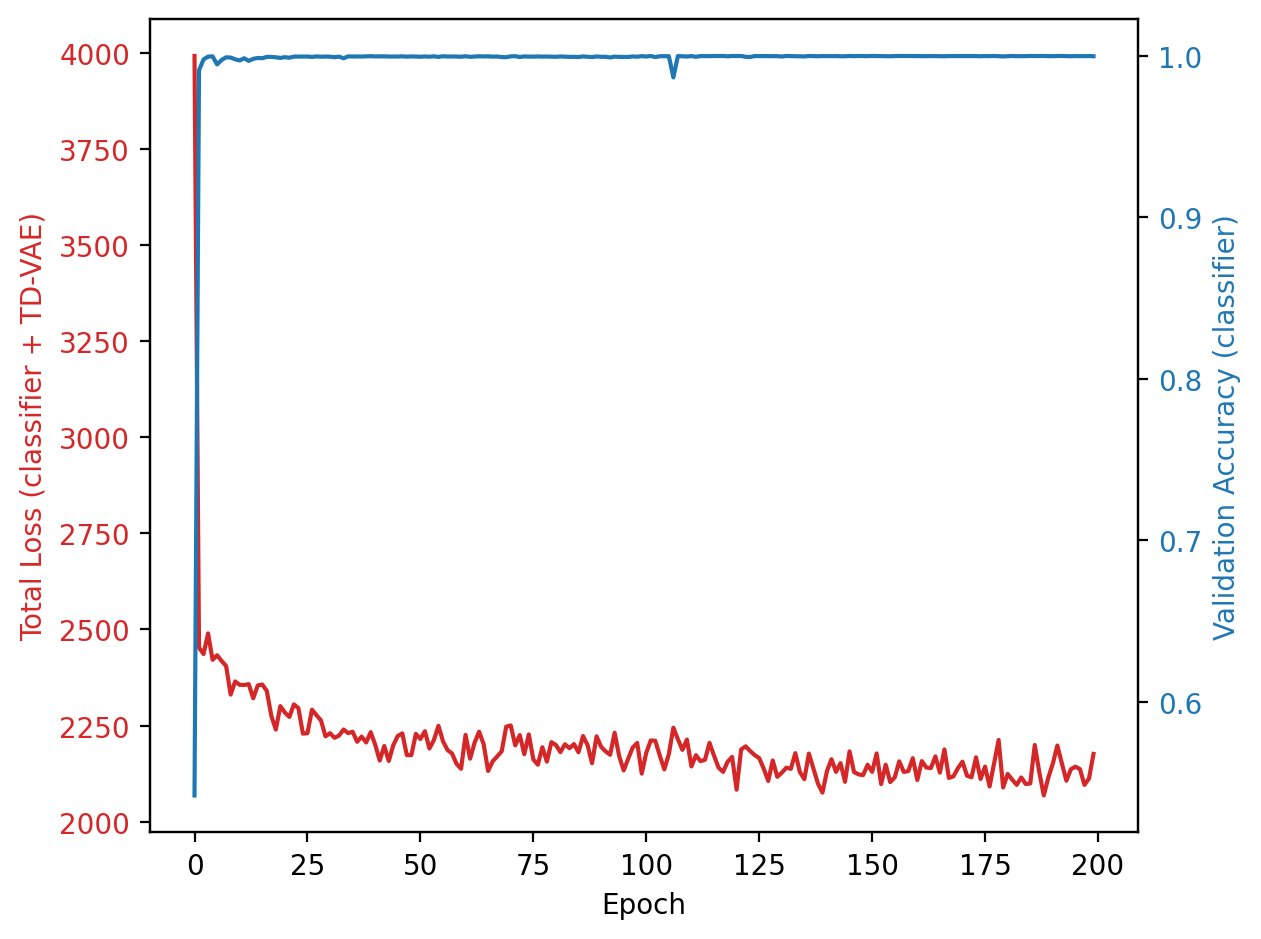

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [14]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

2068.11607382954

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue2.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue2.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 2191.2197: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 1 Train: 2106.3475: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 2 Train: 2167.6762: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9998


Epoch 3 Train: 2050.6474: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9995
2050.647360981376


Epoch 4 Train: 2118.6568: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9997


Epoch 5 Train: 2136.6148: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 0.9999


Epoch 6 Train: 2135.6725: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 2136.8971: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 0.9998


Epoch 8 Train: 2143.2186: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 0.9996


Epoch 9 Train: 2171.5822: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 0.9988


Epoch 10 Train: 2172.8864: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 11 Train: 2127.4603: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 12 Train: 2177.412: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9988


Epoch 13 Train: 2132.7189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9992


Epoch 14 Train: 2122.3615: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00015: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9999


Epoch 15 Train: 2136.1134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9998


Epoch 16 Train: 2139.5063: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 17 Train: 2140.8438: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 18 Train: 2161.515: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 2178.6278: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 20 Train: 2098.3314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 2122.4526: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 22 Train: 2134.095: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 23 Train: 2142.2245: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 2128.2625: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9998


Epoch 25 Train: 2095.4459: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Epoch 00026: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9999


Epoch 26 Train: 2133.1225: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 2120.634: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 28 Train: 2130.969: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 29 Train: 2143.1439: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 2149.149: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9997


Epoch 31 Train: 2083.2201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 32 Train: 2130.3243: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 33 Train: 2109.8806: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 34 Train: 2151.2285: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 2152.9359: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 2134.3425: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9999


Epoch 37 Train: 2159.5393: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 2097.0713: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 2123.6964: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 40 Train: 2143.2498: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 2108.4764: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 42 Train: 2140.1443: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 43 Train: 2073.8002: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 2164.349: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 45 Train: 2096.1114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 2061.5025: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 47 Train: 2118.7201: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00048: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 48 Train: 2078.9441: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 2143.1148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 2099.6862: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 2109.5817: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 52 Train: 2119.851: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 53 Train: 2060.5093: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 2103.5605: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 2166.437: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.02it/s]


Validation Accuracy 0.9999


Epoch 56 Train: 2135.6651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.02it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 2143.381: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 2094.403: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Epoch 00059: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 1.0000


Epoch 59 Train: 2138.8362: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 60 Train: 2113.2329: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 0.9999


Epoch 61 Train: 2116.4874: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.02it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 2129.5917: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 63 Train: 2144.1875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 2115.7471: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 2096.0184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 66 Train: 2079.0376: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 67 Train: 2058.0589: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 2135.516: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 2077.8592: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00070: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 0.9999


Epoch 70 Train: 2137.1587: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 2112.2825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 72 Train: 2082.7092: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 73 Train: 2113.4639: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 2073.5369: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 75 Train: 2116.5657: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.01it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 2073.932: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 2168.9028: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 78 Train: 2104.314: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 2091.9717: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 80 Train: 2107.6357: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Epoch 00081: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 0.9999


Epoch 81 Train: 2133.9284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 82 Train: 2113.47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:08<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 83 Train: 2077.4244: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 2103.2668: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 2097.5932: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 86 Train: 2031.9488: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999
2031.9488339631455


Epoch 87 Train: 2148.9428: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 2136.706: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 89 Train: 2105.0073: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 90 Train: 2036.4315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 2119.9571: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 00092: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 0.9999


Epoch 92 Train: 2119.353: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9999


Epoch 93 Train: 2058.6644: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 2128.3334: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 2093.1231: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 96 Train: 2142.6059: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 97 Train: 2166.8785: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 2182.9476: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 2115.8825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


In [11]:
print(best_loss)

2031.9488339631455


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue2.csv")
log = pd.read_csv("log_root_atlas_20240310_continue2.csv", index_col=0)

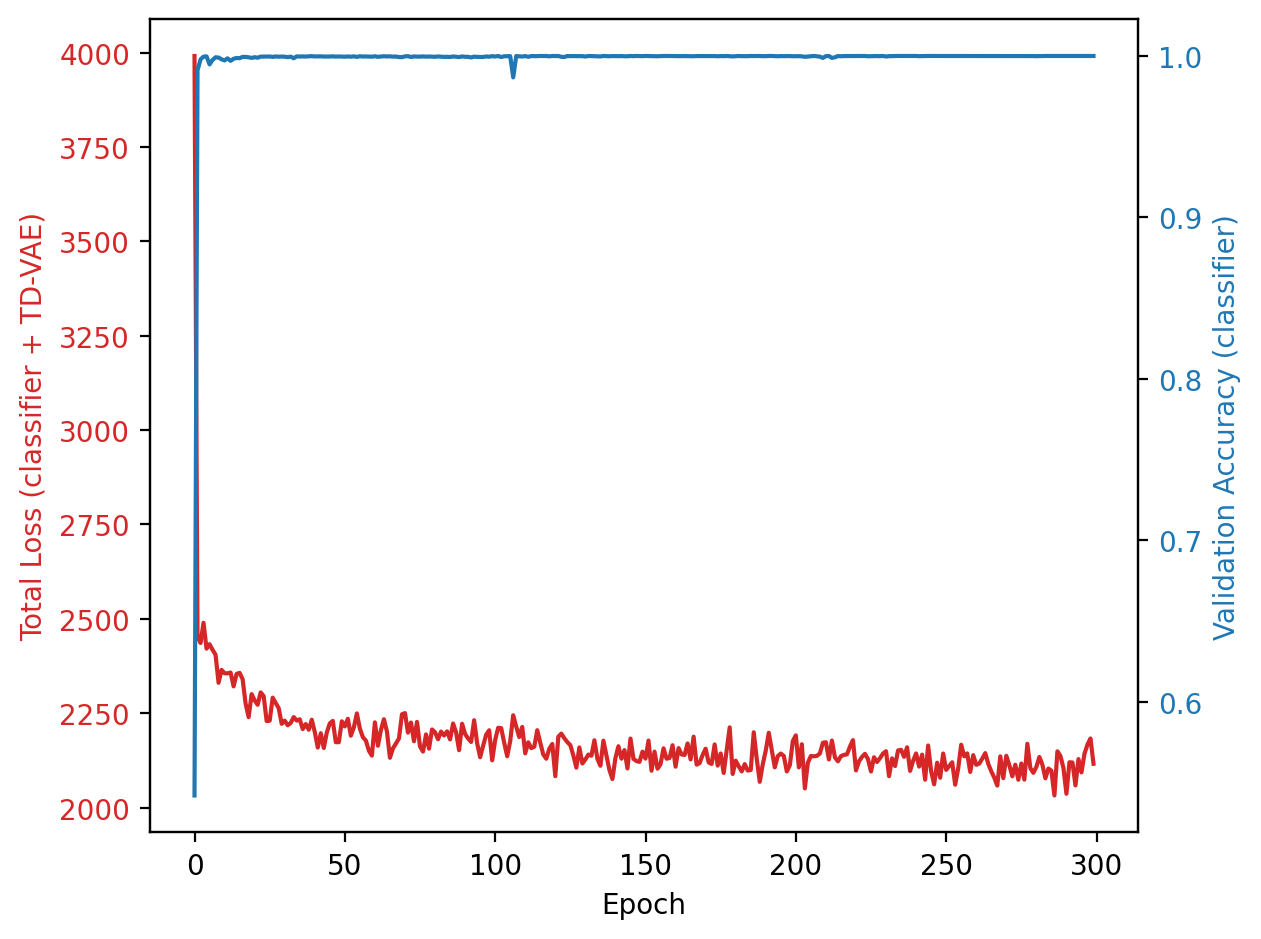

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [14]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue2.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue2.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

2031.9488339631455

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue3.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue3.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 2119.5023: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9995


Epoch 1 Train: 2123.5132: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 2123.4886: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 3 Train: 2121.8696: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 4 Train: 2103.1547: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9997


Epoch 5 Train: 2061.9966: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9998


Epoch 6 Train: 2145.1232: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 0.9999


Epoch 7 Train: 2133.1463: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 8 Train: 2133.4206: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 9 Train: 2088.5157: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 2167.3939: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  2.00it/s]


Validation Accuracy 0.9997


Epoch 11 Train: 2146.3284: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 1.0000


Epoch 12 Train: 2083.0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 2099.5085: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 1.0000


Epoch 14 Train: 2126.5973: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 15 Train: 2071.457: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 16 Train: 2150.4658: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 17 Train: 2110.6839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 2110.6213: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 2118.2497: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 20 Train: 2054.1379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 2099.6757: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9998


Epoch 22 Train: 2089.5674: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 0.9999


Epoch 23 Train: 2104.602: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 2122.7511: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 25 Train: 2136.1891: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 26 Train: 2093.0979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 2096.4998: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 28 Train: 2118.6856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 29 Train: 2066.4001: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 30 Train: 2117.7724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 2112.8241: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 32 Train: 2094.8536: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 33 Train: 2110.2275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9998


Epoch 34 Train: 2173.2132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 2117.5911: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 2132.7085: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 37 Train: 2104.0833: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 38 Train: 2108.6856: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 39 Train: 2095.1649: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 2103.6024: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 41 Train: 2095.0089: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 42 Train: 2122.0391: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 43 Train: 2108.4024: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 44 Train: 2059.8147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 0.9999


Epoch 45 Train: 2097.7197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 46 Train: 2093.2246: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 47 Train: 2091.0791: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 48 Train: 2083.9765: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 49 Train: 2088.6084: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 2093.5214: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 51 Train: 2079.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 52 Train: 2095.9316: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 53 Train: 2102.0515: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 2134.386: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 2079.084: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 0.9999


Epoch 56 Train: 2073.044: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 57 Train: 2105.1307: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 58 Train: 2186.4725: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 2139.1522: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9998


Epoch 60 Train: 2156.0567: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 61 Train: 2115.9559: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.99it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 2100.0532: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 63 Train: 2068.159: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 2120.4651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 2025.6637: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000
2025.6636724057414


Epoch 66 Train: 2108.6105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Epoch 00067: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 67 Train: 2083.2914: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 68 Train: 2093.9367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 2077.5797: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 2096.9701: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 71 Train: 2069.6844: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 72 Train: 2119.0266: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 73 Train: 2128.1575: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 2105.2237: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 2159.6355: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 76 Train: 2082.1125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 77 Train: 2037.6764: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Epoch 00078: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 78 Train: 2140.7549: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 2114.896: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 80 Train: 2141.3947: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.95it/s]


Validation Accuracy 0.9999


Epoch 81 Train: 2121.223: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 2111.1577: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 83 Train: 2076.6651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 84 Train: 2091.7825: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.96it/s]


Validation Accuracy 0.9999


Epoch 85 Train: 2112.7735: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 86 Train: 2140.7275: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 0.9999


Epoch 87 Train: 2126.5551: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 88 Train: 2131.2469: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 00089: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 89 Train: 2139.4315: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 90 Train: 2109.7804: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 2086.7699: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 2119.5541: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 2050.9751: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 2057.8979: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.97it/s]


Validation Accuracy 1.0000


Epoch 95 Train: 2090.3652: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 96 Train: 2093.1088: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 0.9999


Epoch 97 Train: 2153.7672: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 98 Train: 2044.4007: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Validation Accuracy 1.0000


Epoch 99 Train: 2119.6367: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 00100: reducing learning rate of group 0 to 1.9531e-06.
Validation Accuracy 1.0000


In [11]:
print(best_loss)

2025.6636724057414


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue3.csv")
log = pd.read_csv("log_root_atlas_20240310_continue3.csv", index_col=0)

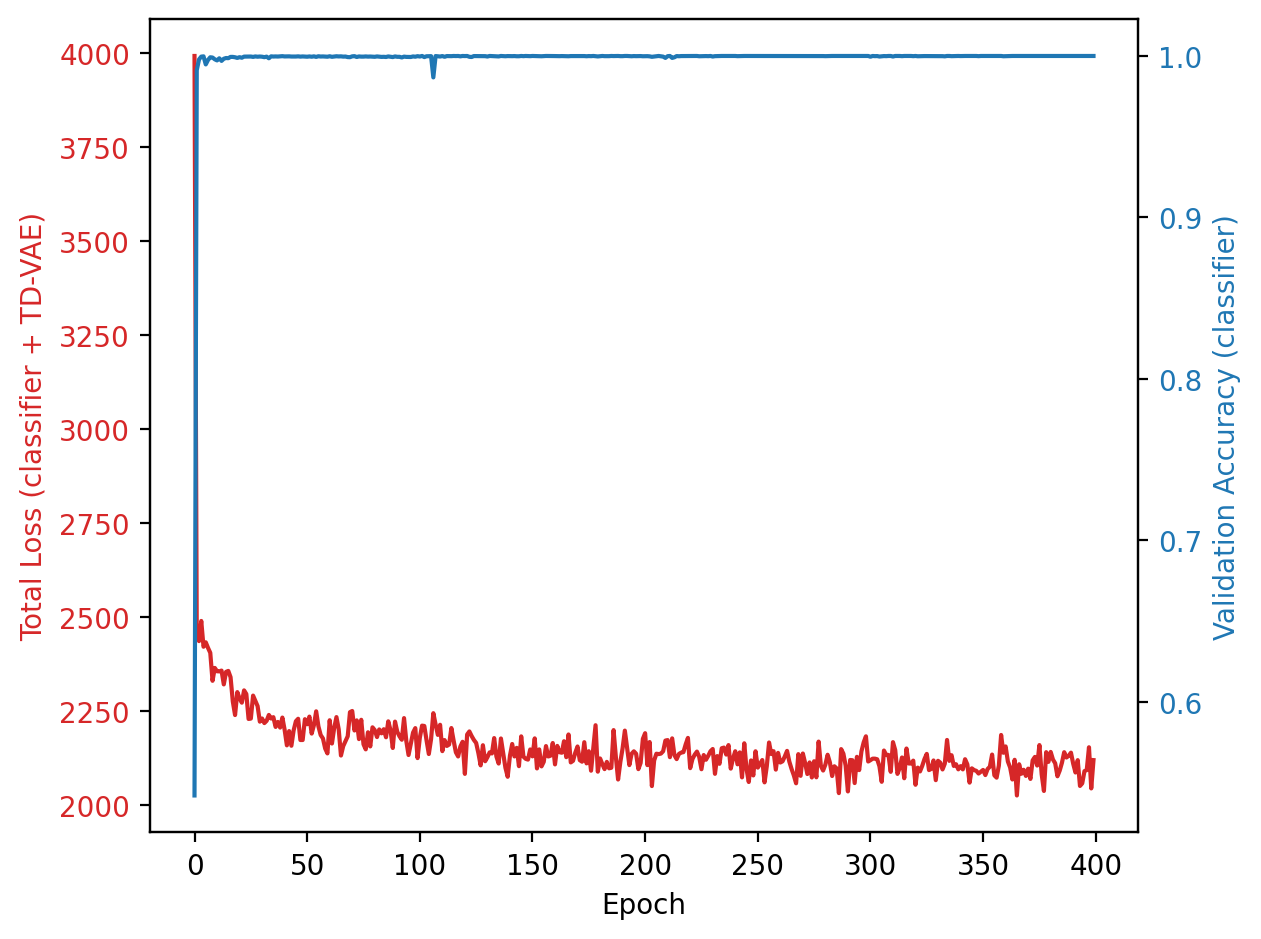

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [14]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [4]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [5]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [6]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [7]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue3.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [8]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue3.pkl', 'rb') as f:
        logger = pickle.load(f)

In [9]:
min(logger['tloss'])

2025.6636724057414

In [10]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue4.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue4.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

Epoch 0 Train: 2154.4286: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:10<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 1 Train: 2126.4212: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 2 Train: 2118.286: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 0.9999


Epoch 3 Train: 2147.5982: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 0.9999


Epoch 4 Train: 2072.3133: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.89it/s]


Validation Accuracy 0.9999


Epoch 5 Train: 2122.6086: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 6 Train: 2089.5621: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 1.0000


Epoch 7 Train: 2125.7755: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 8 Train: 2119.697: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 1.0000


Epoch 9 Train: 2134.3394: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 10 Train: 2131.9971: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 11 Train: 2146.4375: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Validation Accuracy 0.9999


Epoch 12 Train: 2123.1174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:13<00:00,  1.88it/s]


Validation Accuracy 1.0000


Epoch 13 Train: 2147.0819: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 14 Train: 2075.4977: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 15 Train: 2163.6252: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 16 Train: 2135.0938: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 17 Train: 2098.5821: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 18 Train: 2102.1318: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 19 Train: 2103.8601: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 0.9999


Epoch 20 Train: 2077.4921: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 1.0000


Epoch 21 Train: 2090.0378: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 22 Train: 2099.4403: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.
Validation Accuracy 1.0000


Epoch 23 Train: 2118.9072: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 24 Train: 2104.5233: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 25 Train: 2083.2358: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 26 Train: 2109.4338: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 27 Train: 2102.6651: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 28 Train: 2082.5236: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 29 Train: 2113.7948: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 30 Train: 2071.3706: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 31 Train: 2097.3721: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 32 Train: 2121.9192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 33 Train: 2078.8145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Epoch 00034: reducing learning rate of group 0 to 1.2500e-04.
Validation Accuracy 0.9999


Epoch 34 Train: 2110.8147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 35 Train: 2100.7445: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 36 Train: 2125.4168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 37 Train: 2097.6624: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 38 Train: 2094.2991: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 39 Train: 2082.9075: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 40 Train: 2103.5722: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 41 Train: 2124.6706: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 42 Train: 2181.5611: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 43 Train: 2063.8921: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 44 Train: 2072.9558: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Epoch 00045: reducing learning rate of group 0 to 6.2500e-05.
Validation Accuracy 1.0000


Epoch 45 Train: 2073.3101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 46 Train: 2074.9768: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 47 Train: 2120.6447: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 48 Train: 2136.9853: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 1.0000


Epoch 49 Train: 2100.3489: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 50 Train: 2102.9159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9998


Epoch 51 Train: 2060.2544: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 52 Train: 2143.8292: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 53 Train: 2121.4112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Validation Accuracy 1.0000


Epoch 54 Train: 2084.7528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 55 Train: 2092.1379: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.90it/s]


Epoch 00056: reducing learning rate of group 0 to 3.1250e-05.
Validation Accuracy 0.9999


Epoch 56 Train: 2144.0083: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 57 Train: 2086.6046: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 58 Train: 2050.095: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 59 Train: 2065.5385: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 60 Train: 2114.0855: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 61 Train: 2106.3561: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 62 Train: 2109.6299: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 63 Train: 2047.5513: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 64 Train: 2169.8079: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 65 Train: 2041.0897: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 66 Train: 2056.5502: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 67 Train: 2102.1348: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 0.9999


Epoch 68 Train: 2123.4852: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 69 Train: 2059.5776: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 70 Train: 2069.561: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 71 Train: 2094.1842: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9998


Epoch 72 Train: 2096.4109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 73 Train: 2115.8162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 74 Train: 2110.5099: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 75 Train: 2076.9956: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 76 Train: 2082.7629: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Epoch 00077: reducing learning rate of group 0 to 1.5625e-05.
Validation Accuracy 1.0000


Epoch 77 Train: 2119.2724: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 78 Train: 2084.424: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 79 Train: 2036.4778: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 0.9999


Epoch 80 Train: 2059.5943: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 81 Train: 2087.102: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Validation Accuracy 1.0000


Epoch 82 Train: 2129.9839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 83 Train: 2133.4875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 84 Train: 2099.5684: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 85 Train: 2082.3892: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 86 Train: 2033.339: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 87 Train: 2084.9709: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Epoch 00088: reducing learning rate of group 0 to 7.8125e-06.
Validation Accuracy 1.0000


Epoch 88 Train: 2103.7034: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 89 Train: 2083.4341: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 90 Train: 2068.0006: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 1.0000


Epoch 91 Train: 2096.4314: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 92 Train: 2117.1296: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 1.0000


Epoch 93 Train: 2103.8098: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.92it/s]


Validation Accuracy 1.0000


Epoch 94 Train: 2050.1523: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 95 Train: 2093.674: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.94it/s]


Validation Accuracy 0.9999


Epoch 96 Train: 2074.4089: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:11<00:00,  1.93it/s]


Validation Accuracy 0.9999


Epoch 97 Train: 2100.706: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 0.9999


Epoch 98 Train: 2121.8303: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.91it/s]


Epoch 00099: reducing learning rate of group 0 to 3.9063e-06.
Validation Accuracy 1.0000


Epoch 99 Train: 2111.1885: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [01:12<00:00,  1.92it/s]


Validation Accuracy 1.0000


In [11]:
print(best_loss)

2025.6636724057414


In [12]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue4.csv")
log = pd.read_csv("log_root_atlas_20240310_continue4.csv", index_col=0)

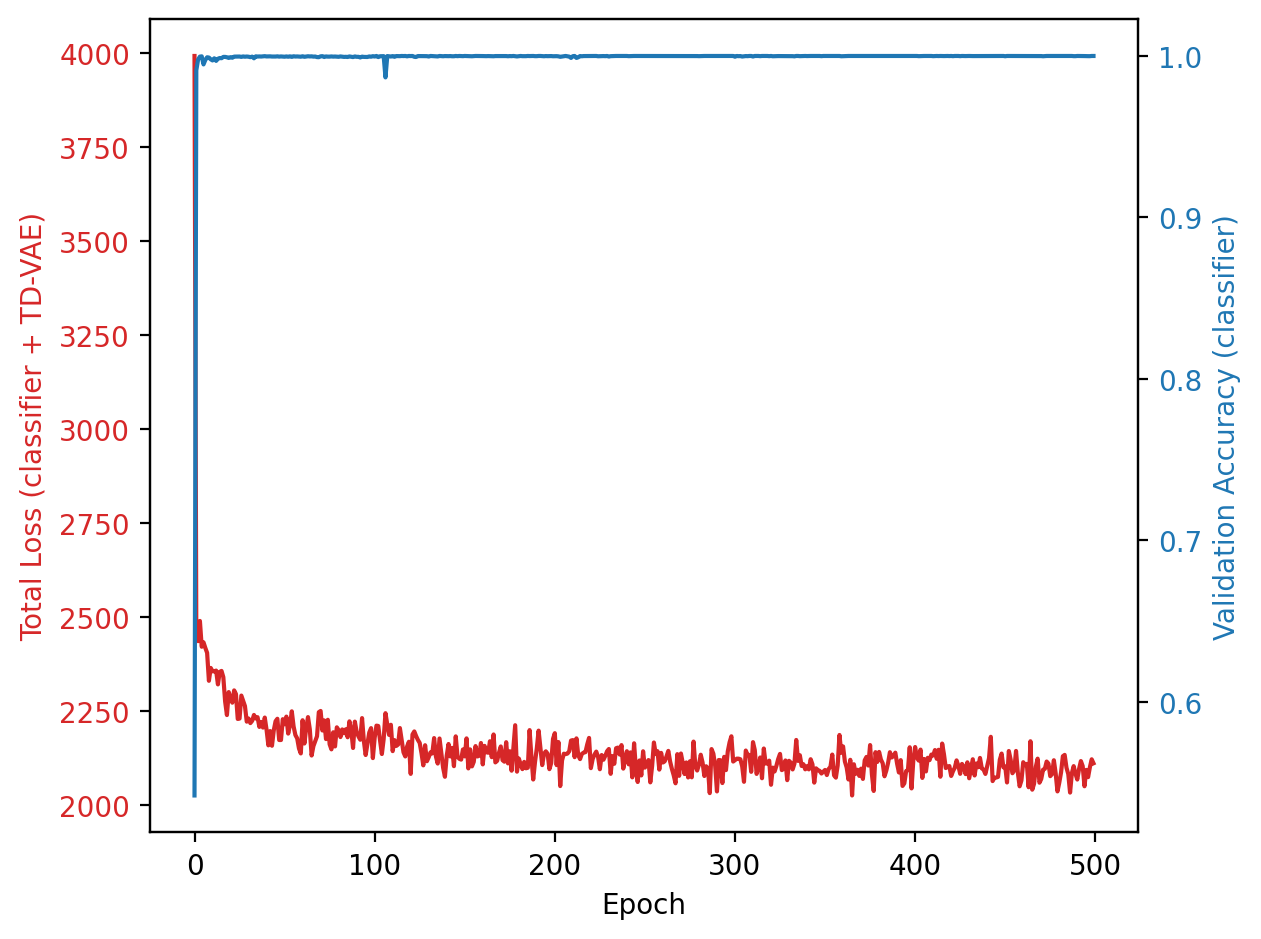

In [13]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue4.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue4.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue5.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue5.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue5.csv")
log = pd.read_csv("log_root_atlas_20240310_continue5.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue5.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue5.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue6.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue6.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue6.csv")
log = pd.read_csv("log_root_atlas_20240310_continue6.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue6.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue6.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue7.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue7.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue7.csv")
log = pd.read_csv("log_root_atlas_20240310_continue7.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue7.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue7.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue8.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue8.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue8.csv")
log = pd.read_csv("log_root_atlas_20240310_continue8.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Continue

In [ ]:
del(data)
del(dataset)
del(loader)
del(train_dataset)
del(train_loader)
del(val_dataset)
del(val_loader)
del(model)

In [ ]:
with open("./genesys_root_SCT_data.pkl", 'rb') as file_handle:
    data = pickle.load(file_handle)
    
batch_size = 512
dataset = Root_Dataset(data['X_test'], data['y_test'])
loader = DataLoader(dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
train_dataset = Root_Dataset(data['X_train'], data['y_train'])
train_loader = DataLoader(train_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)
val_dataset = Root_Dataset(data['X_val'], data['y_val'])
val_loader = DataLoader(val_dataset,
                         batch_size = batch_size,
                         shuffle = True, drop_last=True)

In [ ]:
criterion = torch.nn.NLLLoss()
input_size = data['X_train'].shape[1]
## 10 cell types
output_size = 10
time_bins = 11
embedding_dim = 256
hidden_dim = 256
n_layers = 2
clip = 5
path = "./"
device = "cuda"
n_epochs = 100
train_on_gpu=True

In [ ]:
model = ClassifierLSTM(input_size, output_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
sch = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=0.05, verbose=True)

In [ ]:
checkpoint = torch.load(path+"./genesys_model_trained_on_root_atlas_20240310_continue8.pth")
model.load_state_dict(checkpoint)

In [ ]:
# Load previous logger
with open('log_genesys_model_trained_on_root_atlas_20240310_continue8.pkl', 'rb') as f:
        logger = pickle.load(f)

In [ ]:
min(logger['tloss'])

In [ ]:
#logger = {'tloss': [], 'val_acc': []}
#best_val_acc = 0.99
best_loss = min(logger['tloss'])
for epoch in range(n_epochs):
    h = model.init_hidden(batch_size)
    c, s = 0, 0
    pBar = tqdm(train_loader)
    model.train()
    for sample in pBar:
        h = tuple([each.data for each in h])
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        optimizer.zero_grad()
        t = np.random.choice(time_bins-1)
        p, h = model.predict(x, h, t)
        model.get_belief(x, h)
        tdvae_loss = model.calculate_loss(t)
        nll_loss = criterion(p, y)
        loss = tdvae_loss + nll_loss
        # print(loss)
        s = ((s*c)+(float(loss.item())*len(p)))/(c+len(p))
        c += len(p)
        pBar.set_description('Epoch {} Train: '.format(epoch) +str(round(float(s),4)))
        wl = np.random.choice(2)
        if wl == 0 :
            tdvae_loss.backward()
        else :
            nll_loss.backward()
        #loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    logger['tloss'].append(s)
    sch.step(s)

    val_h = model.init_hidden(batch_size)
    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for sample in val_loader:
            val_h = tuple([each.data for each in val_h])
            x = sample['x'].to(device)
            y = sample['y'].to(device)
            #t = np.random.choice(11)
            t=1
            p, val_h = model.predict_proba(x, val_h, t)
            y_pred.append(p.cpu().detach().numpy())
            y_true.append(y.cpu().detach().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    val_acc = (y_true == y_pred.argmax(axis=1)).mean()
    logger['val_acc'].append(val_acc)
    print("Validation Accuracy {:.4f}".format(val_acc))
    if (val_acc >= 0.99) & (s < best_loss):
        # print('Model improved')
        #best_val_acc = val_acc
        best_loss = s
        print(best_loss)
        torch.save(model.state_dict(), path+"/genesys_model_trained_on_root_atlas_20240310_continue9.pth")
        val_stats = {'pred': y_pred, 'true': y_true}

with open('log_genesys_model_trained_on_root_atlas_20240310_continue9.pkl', 'wb') as f:
    pickle.dump(logger, f)
#if cmat:
    # Plot validation confusion matrix
#    self.plot_cfmt(self.val_stats['pred'], self.val_stats['true'], 0.05, 'val_cfmt.pdf')

In [ ]:
print(best_loss)

In [ ]:
log = pd.DataFrame(logger)
log.to_csv("log_root_atlas_20240310_continue9.csv")
log = pd.read_csv("log_root_atlas_20240310_continue9.csv", index_col=0)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Plot the log

In [14]:
log = pd.read_csv("log_root_atlas_20240310_continue4.csv", index_col=0)

In [153]:
#log.index= range(600)

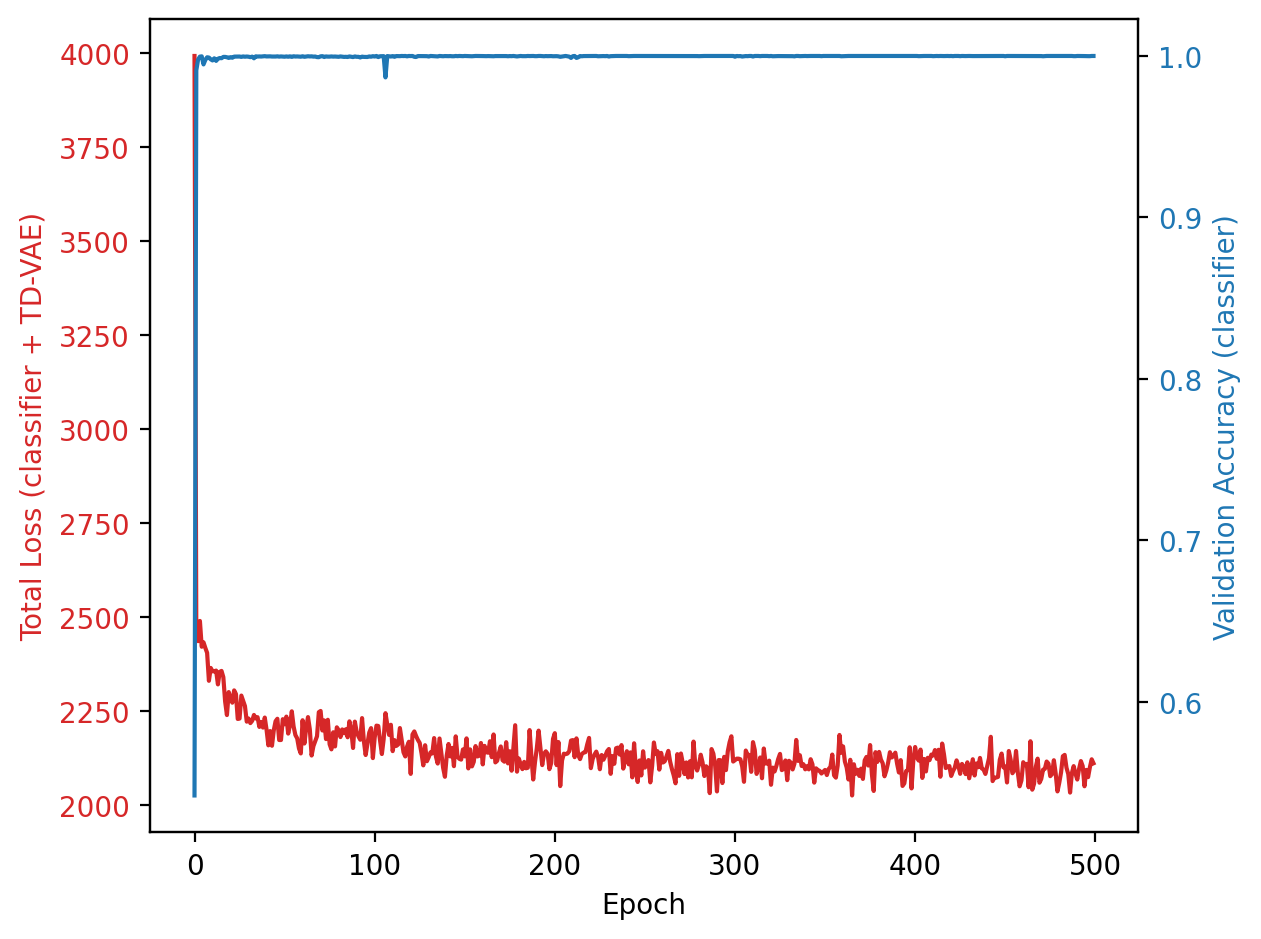

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [16]:
log = log[1:500]

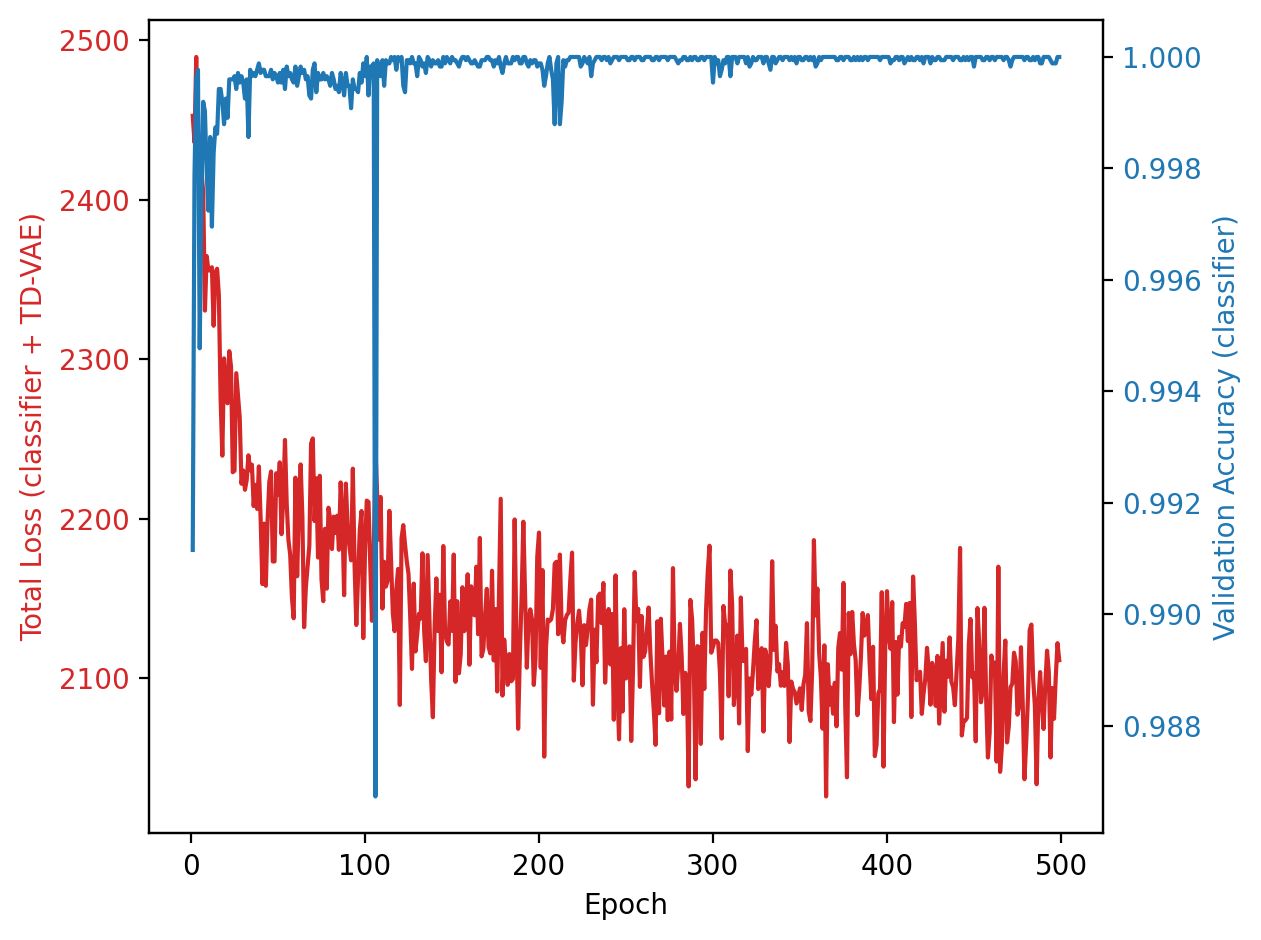

In [17]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss (classifier + TD-VAE)', color=color)
ax1.plot(log.index, log['tloss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy (classifier)', color=color)  # we already handled the x-label with ax1
ax2.plot(log.index, log['val_acc'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()